In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
inspections = spark.read.csv('Food_Inspections.csv', header = True)
inspections.show()

+-------------+--------------------+--------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+---------------+--------------------+------------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|       Facility Type|           Risk|             Address|   City|State|  Zip|Inspection Date|     Inspection Type|        Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+---------------+--------------------+------------------+------------------+--------------------+
|      2555349|      ARIGATO MARKET|      ARIGATO MARKET|  2641941|       Grocery Store|  Risk 1 (High)|   1407 W GRAND AVE |CHICAGO|   IL|60642|     05/05/2022|  

In [3]:
from pyspark.sql.functions import col

df = inspections.select(col('Inspection ID').alias('id'), col('DBA Name').alias('name'), col('Results').alias('results'),\
                        col('Violations').alias('violations'))
df.registerTempTable('CountResults')
df.show()

/usr/local/spark/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


+-------+--------------------+---------------+--------------------+
|     id|                name|        results|          violations|
+-------+--------------------+---------------+--------------------+
|2555349|      ARIGATO MARKET|       No Entry|                null|
|2555341|CLOWNS PANCAKE HO...|           Pass|37. FOOD PROPERLY...|
|2555286|LA GUERITA MEXICA...|           Pass|                null|
|2555284|LA TAPENADE GATE H14|           Pass|                null|
|2555265|   STAN'S DONUTS MSI|      Not Ready|                null|
|2555259|  BANG BANG BISCUITS|       No Entry|                null|
|2555263|   LIL BUDDY'S, INC.|           Pass|                null|
|2555240|      LEE ELEMENTARY|           Pass|53. TOILET FACILI...|
|2555235|ARAMARK EDUCATION...|           Pass|57. ALL FOOD EMPL...|
|2555224|GAN SHALOM (TEMPL...|           Pass|51. PLUMBING INST...|
|2555204|FROM HERE ON FOOD...|           Pass|                null|
|2555209|  SAM FOOD & GROCERY|Out of Business|  

In [4]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|           Not Ready|
|                Fail|
|            No Entry|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+



In [5]:
countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()

(-1.1091860581010853,
 1.1004374327687274,
 -1.1064130382999895,
 1.1074430329973606)

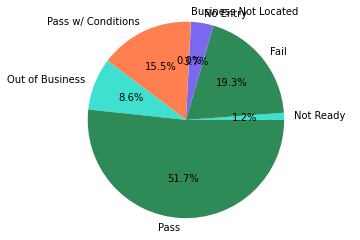

In [6]:
import matplotlib.pyplot as plt

labels = countResultsdf['results']
sizes = countResultsdf['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [7]:
splits = df.randomSplit([0.2, 0.8])
train = splits[0]
test = splits[1]

In [8]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = train.select(label(df.results).alias('label'), df.violations).where('label >= 0')

In [9]:
labeledData.show()

+-----+--------------------+
|label|          violations|
+-----+--------------------+
|  1.0|                null|
|  0.0|1. SOURCE SOUND C...|
|  1.0|33. FOOD AND NON-...|
|  1.0|                null|
|  0.0|26. ADEQUATE NUMB...|
|  1.0|34. FLOORS: CONST...|
|  1.0|34. FLOORS: CONST...|
|  1.0|35. WALLS, CEILIN...|
|  1.0|36. LIGHTING: REQ...|
|  1.0|                null|
|  1.0|37. TOILET ROOM D...|
|  1.0|32. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|30. FOOD IN ORIGI...|
|  1.0|32. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|43. FOOD (ICE) DI...|
|  1.0|                null|
|  1.0|38. VENTILATION: ...|
|  0.0|                null|
+-----+--------------------+
only showing top 20 rows



In [10]:
labeledData = labeledData.na.fill({'violations': ''})
labeledData.show()

+-----+--------------------+
|label|          violations|
+-----+--------------------+
|  1.0|                    |
|  0.0|1. SOURCE SOUND C...|
|  1.0|33. FOOD AND NON-...|
|  1.0|                    |
|  0.0|26. ADEQUATE NUMB...|
|  1.0|34. FLOORS: CONST...|
|  1.0|34. FLOORS: CONST...|
|  1.0|35. WALLS, CEILIN...|
|  1.0|36. LIGHTING: REQ...|
|  1.0|                    |
|  1.0|37. TOILET ROOM D...|
|  1.0|32. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|30. FOOD IN ORIGI...|
|  1.0|32. FOOD AND NON-...|
|  1.0|33. FOOD AND NON-...|
|  1.0|43. FOOD (ICE) DI...|
|  1.0|                    |
|  1.0|38. VENTILATION: ...|
|  0.0|                    |
+-----+--------------------+
only showing top 20 rows



In [11]:
labeledData.count()

40461

In [12]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.1)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


model = pipeline.fit(labeledData)

In [22]:
testDf = test.where("results = 'Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")
testDf = test.na.fill({'violations': ''})
predictionsDf = model.transform(testDf)
predictionsDf.registerTempTable('Predictions')
predictionsDf.show()

+-------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     id|                name|        results|          violations|               words|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| 100213|       SUNDAY DINNER|           Pass|                    |                  []|(262144,[249180],...|[-2.6341903789913...|[0.06697013857677...|       1.0|
|1072240|EZZARD CHARLES NU...|           Pass|34. FLOORS: CONST...|[34., floors:, co...|(262144,[2325,293...|[-2.8532385023829...|[0.05451415613245...|       1.0|
|1072251|        #1 CHOP SUEY|           Pass|                    |                  []|(262144,[249180],...|[-2.6341903789913...|[0.06697013857677...|       1.0|
|1072274|KENTUCKY FRIE

In [23]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR
                                        (prediction = 1 AND (results = 'Pass' OR
                                                            results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print("There were", numInspections, "inspections and there were", numSuccesses, "successful predictions")
print("This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate")

There were 188769 inspections and there were 150564 successful predictions
This is a 79.76097770290673% success rate


In [24]:
true_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'").toPandas()

In [26]:
false_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").toPandas()

In [28]:
true_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND results = 'Fail'").toPandas()

In [41]:
true_positive.at[0,'cnt']

26770

In [30]:
false_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").toPandas()

(-1.1051242913372241,
 1.100244016933441,
 -1.1008911443530143,
 1.1048550620018287)

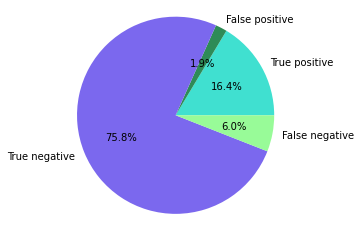

In [42]:
labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive.at[0, 'cnt'], false_positive.at[0, 'cnt'], false_negative.at[0, 'cnt'], true_negative.at[0, 'cnt']]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')